In [258]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")


In [259]:
from langchain_groq import ChatGroq

In [260]:
import wikipediaapi
import wikipedia
from serpapi import GoogleSearch

In [261]:
llm = ChatGroq(model="Gemma2-9b-It", temperature=0.2)

In [262]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState

In [263]:
sys_msg1 = SystemMessage (content = "You are a helpful assistant tasked with generating blog title, pick the first catchy title.")
sys_msg2 = SystemMessage (content = "You are writing the blog using {query}. Use the following search results {combined_result} for generation. \
                          You will generate the following 3 sections. \
                          1. introduction (50 words stating the core problem) \
                          2. main body containing technical details and problem solution within 300 words. \
                          3. Conclusion (50 words, summarizing the key messages. Make it concise and impactful). \
                          Ensure to mention clear section titles and bullet points. ")
#sys_msg3 = SystemMessage (content = "You are a helpful assistant tasked with generating concise and impactful ending within 50 words. Pick the first impactful ending. Clealy state Conclusion as the heading of the section.")

In [265]:
wiki_obj = wikipediaapi.Wikipedia(user_agent= "MyAIApp/1.0 (ravibhattinkw@gmail.com)",language="en")
def clean_query(query):
        
        ignore_words = ["Generate a blog on", "Write about", "What is", "Who is", "Explain"]
    
        for word in ignore_words:
            query = query.replace(word, "").strip()

        return query  # Return cleaned-up query for better Wikipedia search

def fetch_wiki_data(query):

    query = clean_query(query)

    get_wiki_page = wikipedia.search(query)

    #print("Get Wiki Page:",get_wiki_page)

    #best_match = wiki_obj.page (get_wiki_page[1]) # Fetch from wikipedia
    for match in get_wiki_page:
        try:
            return wikipedia.summary(match, sentences=3)  # Limit to 3 sentences
        except wikipedia.exceptions.PageError:
            continue  # Try next title if PageError occurs
        except wikipedia.exceptions.DisambiguationError as e:
            return f"Multiple results found: {e.options[:5]}..."  # Show first 5 options
    
    #if best_match.exists():
    #    return wikipedia.summary(best_match, sentences=5)
    #else:
    #    "No Wikipedia data found"

#print(fetch_wiki_data("Generate a blog on Greatness of Novak Djokovic?"))

In [ ]:
def fetch_google_search_results(query):
    # Search Google with serper API
    params = {
        "engine": "google",
        "q": query,
        #"api_key": os.environ["SERPER_API_KEY"
    }

    search = GoogleSearch(params)
    results = search.get_dict()
    #print("🔍 Raw API Response:", results)

    top3_search = [result["snippet"] for result in results.get("organic_results", [])[:3]]  # Get top 3 snippets
    return " ".join(top3_search) if top3_search else "No relevant search results found."

In [270]:
def title_generator(state: MessagesState):
    title = llm.invoke([sys_msg1] + state["messages"])  # No config needed
    return {"messages": state["messages"] + [title]}

def mainbody_generator(state: MessagesState):
    title_msg = state["messages"][-1]  

    query = state["messages"][0].content

    #print("query:",query)

    wiki_info = fetch_wiki_data(query)

    #print("Wiki_info",wiki_info)
    
    google_search_info = fetch_google_search_results(query)

    combined_result = f"Wikipedia Result: {wiki_info} \n  Google Search Result: {google_search_info}"

    #print("combined_result:", combined_result)
    
    main_body = llm.invoke([sys_msg2] + [title_msg])  
    return {"messages": state["messages"] + [main_body]}

#def conclusion_generator(state: MessagesState):
#    relevant_messages = state["messages"][-2:]  
#    conclusion = llm.invoke([sys_msg3] + relevant_messages)  
#    return {"messages": state["messages"] + [conclusion]}

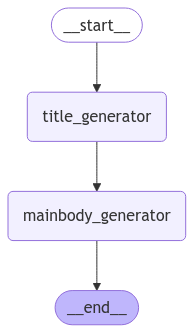

In [271]:
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node( "title_generator", title_generator)
builder.add_node( "mainbody_generator", mainbody_generator)
#builder.add_node( "conclusion_generator", conclusion_generator)

builder.add_edge ( START, "title_generator" )
builder.add_edge ( "title_generator", "mainbody_generator" )
builder.add_edge ( "mainbody_generator", END)
#builder.add_edge ( "mainbody_generator", "conclusion_generator")
#builder.add_edge ( "conclusion_generator", END)

react_graph = builder.compile()

display (Image(react_graph.get_graph().draw_mermaid_png()))

#messages = [HumanMessage(content = "Generate a blog on Good AI Governance")]
#messages = react_graph.invoke({ "messages": messages})

#for m in messages['messages']:
    #m.pretty_print()

In [ ]:
messages = [HumanMessage(content = "Generate a blog on Greatness of Novak Djokovic")]
messages = react_graph.invoke({ "messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Generate a blog on Greatness of Novak Djokovic
================================== Ai Message ==================================

##  Djokovic: The Maestro of the Court - A Legacy Forged in Grit and Grace 


Let's dive into a blog post celebrating Novak Djokovic's greatness!
================================== Ai Message ==================================

 
### Introduction

Novak Djokovic's dominance in tennis is undeniable.  He's consistently ranked among the world's best, but his journey to the top wasn't paved with privilege. This blog explores the technical aspects of his game and the mental fortitude that have made him a true champion.

###  The Djokovic Formula: Technique and Tenacity

Djokovic's success stems from a potent combination of exceptional technique and unwavering mental strength. 

* **Unmatched Return of Serve:** Djokovic's return of serve is legendary. He anticipates the serve's trajec